In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import csv

from statistics import mean, stdev
from pytrends.request import TrendReq
from urllib3.exceptions import MaxRetryError

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

# our modules
from plotSeries import *
from checkStationarity import *
from GoogleTrendsData import *
from makeDataQuarterly import *
from makeSeriesStationary import *
from predictorsSelection import *
from dataPreProcessing import *
from tsModels import *
from rollingPredictionfuns import *
from fittedAndPredictedValuefuns import *
from bootstrapfuns import *

# Read all data 

In [3]:
################################################################################
##########                     Read  Data                      #################
################################################################################

################################## GDP Data ###################################################
# Read statCan data for GDP
warnings.filterwarnings("ignore")
gdp_path = '../../data/expenditure/expenditure_gdp_new.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])

# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

# create copy of original data to use later
gdp_original = gdpts.copy()

# calculate and add growth rate to the dataframe
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

# Read trends data for GDP
categoryts = pd.read_csv('../../data/storeddata/gdp_category_ts.csv', index_col=0)


################################## Retail Trades Data ###################################################
# Reading file
retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')
# Renaming columns as required
retailsales.rename(columns = {'REF_DATE':'date', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['date'] >= '2004-01')]
retailsales_final = retailsales_filtered[['date', 'VALUE']].copy()

#Changing data type of date
retailsales_final['date'] =  pd.to_datetime(retailsales_final['date'])
retailsales_final = retailsales_final.set_index('date')
retailsales_initial = retailsales_final.copy()

# calculate and add growth rate to the dataframe
retailsales_final['GrowthRate']=retailsales_final['VALUE'].pct_change()
retailsales_final = retailsales_final.dropna()

# Read Trends data for retial trade sales
corrcat = pd.read_csv('../../data/storeddata/FinalRetailData.csv')
corrcat = corrcat.set_index('date')
corrquery = pd.read_csv('../../data/storeddata/keywords_query_nonstationary.csv')
corrquery = corrquery.set_index('date')

################################## E-Commerce Data ###################################################
# Reading file
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])
# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})
retailEcommercesales_ts = retailEcommercesales.copy()
#Changing data type of date
retailEcommercesales=retailEcommercesales.set_index(['Date'])
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)
retailEcommercesales_ts = retailEcommercesales_ts.set_index('Date')
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts.index)
# calculate and add growth rate to the dataframe
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA

# Read and process trends data
ecommerce_keyword_ts = pd.read_csv('../../data/storeddata/EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

# Fit Models

In [4]:
####################### Make data stationary ###############################
## GDP 
# select predictors and make them stationary
less_predictors = select_variables_with_correlation(gdpts, categoryts)
temp_cat = get_gdp_data_quarterly(less_predictors, match='0')
tempcat = remove_seasonality(detrend(normalize(temp_cat)))
# response
response_gdp = gdpts[['GDP_GrowthRate']]
# Make predictors dataframe in right form
predictor_gdp = make_predictors_df(tempcat)

## Retail Trades sales
warnings.filterwarnings("ignore")
# getting lag values and storing response and predictors for Random Forest
corrcat.index = pd.to_datetime(corrcat.index)
rf_predictors, rf_response_var = get_lag1_data(corrcat, corrquery, retailsales_final, response_var='GrowthRate')

# E-commerce
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (detrend(normalized_ecommerce_keyword))
# response and predictors structing
predictor = make_predictors_df(detrend_ecommerce_keyword)
response = make_predictors_df(retailEcommercesales_ts[['Growth_rate']])


######################### Fit Models #####################################
### GDP ###
# Apply DFM
factors = apply_dfm(predictor_gdp, num_factors=20, order_factors=1)

# split train, test and extra test set (use 13 factors as predictors)
train, test, extra_test = ts_train_test_split(response_gdp, factors.iloc[:, 0:13], test_size=0.2)

modelfit = fit_arima_model(train)
pred_gdpGrowth = rolling_prediction(train, test, extra_test)
pred_error_gdp, fig_gdp, fitted_predicted_data_gdp = fitted_and_predicted_gdp(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test)

## Retail Trades Sales - Apply Random Forest
#Splitting data in training and testing
train_rf, test_rf, extra_rf = ts_train_test_split(rf_response_var, rf_predictors, test_size=0.3)
#Fitting RF model
rfmodel = randomForest_modelfit(train_rf, response_var='GrowthRate', n_trees=100)
x_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['GrowthRate'])], train_rf[['GrowthRate']]
# fitted growth rate
fitted_growthRate_rf = rfmodel.predict(x_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted GrowthRate'})
fitted_growthRate_rf.index = train_rf.index
#Random Forest Predictions
rf_pred_retailgrowth = rolling_prediction_RF(train_rf, test_rf, extra_rf,dependent_var='GrowthRate',
                                              n_trees=100)
#rf_pred_retailgrowth
# Fitted and predicted retail sales value
pred_error_rs, fig_rs, data_rs = fitted_and_predicted_retail(rfmodel, 
                                                    rf_pred_retailgrowth, 
                                                    retailsales_initial, train_rf, test_rf, extra_rf)

### E-commerce - Random Forest
rf_predictors_e, rf_response_e = get_lag1_data_ecommerce(retailEcommercesales_ts, detrend_ecommerce_keyword, response_var='Growth_rate')
#Splitting data in training and testing
train_rf_e, test_rf_e, extra_rf_e = ts_train_test_split(rf_response_e, rf_predictors_e, test_size=0.2)
#Fitting RF model
rfmodel_e = randomForest_modelfit(train_rf_e, response_var='Growth_rate', n_trees=600)
x_rf_e, y_rf_e = train_rf_e.loc[:, ~train_rf_e.columns.isin(['Growth_rate'])], train_rf_e[['Growth_rate']]
# fitted growth rate
fitted_growthRate_rf_e = rfmodel_e.predict(x_rf_e)
fitted_growthRate_rf_e = pd.DataFrame(fitted_growthRate_rf_e, columns={'Fitted GrowthRate'})
fitted_growthRate_rf_e.index = train_rf_e.index
#Random Forest Predictions
rf_pred_ecommercegrowth = rolling_prediction_randomForest(train_rf_e, test_rf_e, extra_rf_e,dependent_var='Growth_rate',
                                              n_trees=600)
#rf_pred_retailgrowth
# Fitted and predicted retail sales value
pred_error_e, fig_e, data_e = fitted_and_predicted_sales_ecommerce(rfmodel_e, 
                                                    rf_pred_ecommercegrowth, 
                                                    retailEcommercesales, train_rf_e, test_rf_e, extra_rf_e)

# BootStrap

In [5]:
## Bootstrap for GDP
# create bootstrap samples
bs_samples = get_bootstrap_samples(train, n_sample=200, block_size=9, rs=None)  # rs = RandomState(1234)
# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction(df, test, extra_test, dependent_var='GDP_GrowthRate')
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]
# get predicted gdp value for bootstrap samples
predicted_gdp_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, gdp_data = fitted_and_predicted_gdp(modelfit, predicted_growth_rate_temp, gdp_original, train, test, extra_test)
    predicted_gdp_df_bs.iloc[:, i] = gdp_data['Predicted GDP'].dropna()

## Bootstrap for Retail Trade Sales
# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf, n_sample=200, rs=None)  # RandomState(1234)
# get predicted growth rate uisng bootstrap samples
predicted_rsales_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_rsales_temp = rolling_prediction_RF(df, test_rf, extra_rf, dependent_var='GrowthRate')
    predicted_rsales_df.iloc[:, i] = predicted_rsales_temp[0]
# get predicted RTS value for bootstrap samples
predicted_retail_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i in range(0, len(bs_samples)):
    predicted_growth_rate_temp = predicted_rsales_df[[i]].rename(columns={i: 0})
    _, _, retail_data = fitted_and_predicted_retail(rfmodel, predicted_growth_rate_temp, retailsales_initial, train_rf, test_rf, extra_rf)
    predicted_retail_df_bs.iloc[:, i] = retail_data['Predicted Retail'].dropna()

## E-Commerce 
# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf_e, n_sample=200, block_size=9, rs=None)
# get predicted growth rate uisng bootstrap samples
predicted_growth_df_e = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction_randomForest(df, test_rf_e, extra_rf_e, dependent_var='Growth_rate',n_trees=100)
    predicted_growth_df_e.iloc[:, i] = predicted_growth_temp[0]
# get predicted gdp value for bootstrap samples
predicted_e_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df_e[[i]].rename(columns={i: 0})
    _, _, e_data = fitted_and_predicted_sales_ecommerce(rfmodel_e, predicted_growth_rate_temp, retailEcommercesales, train_rf_e, test_rf_e, extra_rf_e)
    predicted_e_df_bs.iloc[:, i] = e_data['Predicted Retail'].dropna()

In [6]:
# GDP
fig1_gdp, pred_gdp_growth_data = growth_rate_plot_and_data_bs(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= modelfit, 
                              gdpts = gdpts, 
                              train = train,
                              pred_gdpGrowth = pred_gdpGrowth)

fig2_gdp, pred_gdp_data = gdp_plot_and_data_bs(modelfit, pred_gdpGrowth, gdp_original, train, test, extra_test, predicted_gdp_df_bs,
                                          lower_q = 0.025, upper_q = 0.975)

# Retail Trade
fig1_rs, pred_rs_growth_data = growth_rate_plot_and_data_RTS(predicted_growth_df=predicted_rsales_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel, 
                              retailsales_final = retailsales_final, 
                              train = train_rf,
                              rf_pred_retailgrowth = rf_pred_retailgrowth,
                              fitted_growthRate_rf = fitted_growthRate_rf)    
    
fig2_rs, pred_retail_data = retail_plot_and_data_bs(rfmodel, 
                                                 rf_pred_retailgrowth, 
                                                 retailsales_initial, 
                                                 train_rf, 
                                                 test_rf, 
                                                 extra_rf, 
                                                 predicted_retail_df_bs,
                                                lower_q = 0.025, upper_q = 0.975)
## E-Commerce
fig1_e, pred_e_growth_data = growth_rate_plot_and_data_bs_ecommerce(predicted_growth_df=predicted_growth_df_e,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel_e, 
                              retailEcommercesales_ts = retailEcommercesales_ts, 
                              train = train_rf_e,
                              pred_gdpGrowth = rf_pred_ecommercegrowth,fitted_growthrate=fitted_growthRate_rf_e)
fig2_e, pred_e_data = ecommerce_plot_and_data_bs(rfmodel_e, rf_pred_ecommercegrowth, 
                                          retailEcommercesales, train_rf_e, test_rf_e, extra_rf_e, predicted_e_df_bs, 
                                          lower_q = 0.025, upper_q = 0.975)

In [7]:
pred_gdp_growth_data.to_csv('../../data/storeddata/GDP_GrowthRateResults.csv')
pred_gdp_data.to_csv('../../data/storeddata/GDP_ValueResults.csv')
pred_rs_growth_data.to_csv('../../data/storeddata/RTS_GrowthRateREsults.csv')
pred_retail_data.to_csv('../../data/storeddata/RTS_ValueResults.csv')
pred_e_growth_data.to_csv('../../data/storeddata/Ecomm_GrowthRateResults.csv')
pred_e_data.to_csv('../../data/storeddata/Ecomm_ValueResults.csv')

# opening the csv file in 'w' mode
file = open('../../data/storeddata/PredictionErrors.csv', 'w', newline ='')
 
with file:
    # identifying header 
    header = ['GDP', 'RTS', 'ECOM']
    writer = csv.DictWriter(file, fieldnames = header)
     
    # writing data row-wise into the csv file
    writer.writeheader()
    writer.writerow({'GDP' : pred_error_gdp,
                     'RTS': pred_error_rs,
                     'ECOM': pred_error_e})

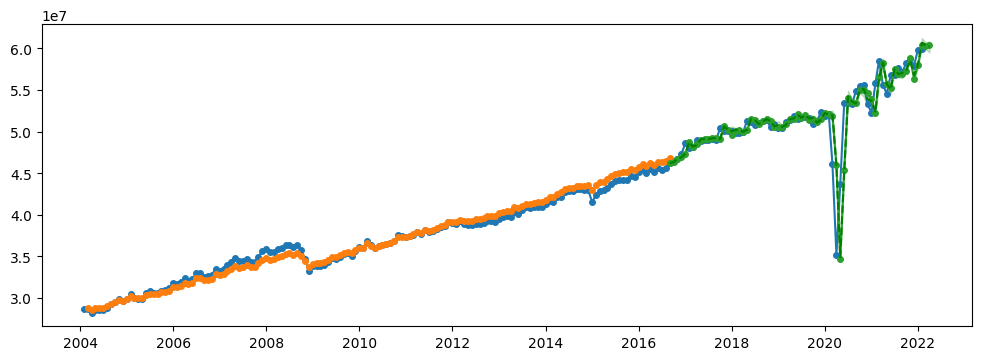

In [13]:
fig2_rs